In [1]:
!pip install statsmodels


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [61]:
import numpy as np
from scipy.stats import bernoulli
import statsmodels.api as sm
import pandas as pd

np.random.seed(0)

def simulate_ar(n, p, beta=0.5):
    """
    Simulate n AR(1) processes each with p observations.
    n: Number of variables (series)
    p: Number of observations in each series
    beta: AR(1) coefficient
    """
    X = np.zeros((n, p))
    for i in range(n):  # Iterate over each series
        X[i, 0] = np.random.normal()  # Initialize the first value of each series
        for j in range(1, p):  # Iterate over each time point
            noise = np.random.normal()
            X[i, j] = beta * X[i, j - 1] + noise
    return X




def compute_settings_output(X):
    """
    Compute the output for the two settings.
    """
    output_setting_1 = compute_setting1_output(X)
    output_setting_2 = compute_setting2_output(X)
    return output_setting_1, output_setting_2


def compute_setting1_output(X):
    """
    Y | X ~ Bernoulli(0.5)
    """
    return bernoulli.rvs(0.5, size=X.shape[0])


def compute_setting2_output(X):
    """
    Y | X ~ Bernoulli(logit(0.08*(X2 + ... + X21)))
    """
    linear_combination = 0.08 * np.sum(X[:, 1:21], axis=1)
    probability = 1 / (1 + np.exp(-linear_combination))
    return bernoulli.rvs(probability)

In [73]:
## version with numpy array
import numpy as np
import statsmodels.api as sm


# Assuming simulate_ar, compute_setting1_output, and compute_setting2_output are defined elsewhere

def simulation(iterations=1000, n=500, p=200):
    """
    Simulate the two Random variables and fit the models.
    n: Number of observations
    p: Number of variables
    iterations: Number of iterations
    """
    # Assuming p-1 because we're excluding the intercept
    total_rows = iterations * 2
    results = np.empty((total_rows, 5), dtype=object)  # Pre-allocate NumPy array

    idx = 0
    for i in range(iterations):

        if i % 100 == 0: print(f"Reached iteration {i}..")
        try:
            xs = simulate_ar(n, p)
            #xs = simulate_ar_V2(n, p)

            ys1 = compute_setting1_output(xs)
            ys2 = compute_setting2_output(xs)

            model1 = sm.Logit(ys1, sm.add_constant(xs)).fit(disp=0)
            model2 = sm.Logit(ys2, sm.add_constant(xs)).fit(disp=0)

            # add only coeff beta1
            results[idx] = [i, 'Global Null', n, p, model1.pvalues[1]]
            idx += 1
            results[idx] = [i, '20 Nonzero Coefficients', n, p, model2.pvalues[1]]
            idx += 1

        except np.linalg.LinAlgError:
            print(f"Skipping iteration {i} due to singular matrix error.")
            continue

    return results


results1 = simulation(iterations=1000)

Reached iteration 0..
Reached iteration 100..
Reached iteration 200..
Reached iteration 300..


C:\Users\danpa\PycharmProjects\CStat_assignments\venv\lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\danpa\PycharmProjects\CStat_assignments\venv\lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Skipping iteration 316 due to singular matrix error.
Reached iteration 400..
Reached iteration 500..
Reached iteration 600..


C:\Users\danpa\PycharmProjects\CStat_assignments\venv\lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\danpa\PycharmProjects\CStat_assignments\venv\lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Skipping iteration 607 due to singular matrix error.
Reached iteration 700..
Reached iteration 800..


C:\Users\danpa\PycharmProjects\CStat_assignments\venv\lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\danpa\PycharmProjects\CStat_assignments\venv\lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Skipping iteration 870 due to singular matrix error.
Reached iteration 900..


C:\Users\danpa\PycharmProjects\CStat_assignments\venv\lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\danpa\PycharmProjects\CStat_assignments\venv\lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Skipping iteration 989 due to singular matrix error.


Text(0.5, 1.0, 'Hisgoragram of Beta1: Global Null')

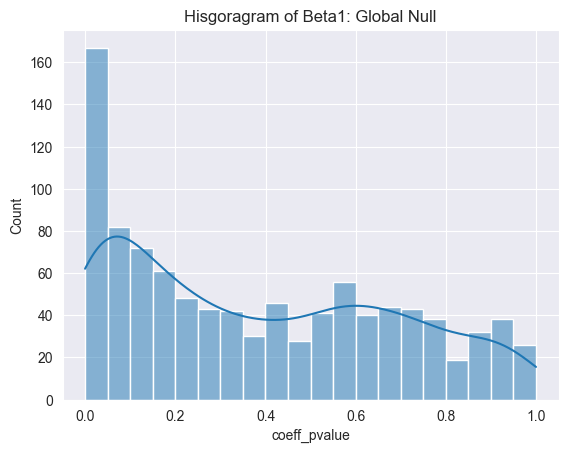

In [74]:
simulation_df = pd.DataFrame(columns=['SimIdx', 'Setting', 'n', 'p', 'coeff_pvalue'], data=results1)

import seaborn as sns

sns.histplot(data=simulation_df[simulation_df['Setting'] == 'Global Null'], x='coeff_pvalue', kde=True,
             bins=20).set_title('Hisgoragram of Beta1: Global Null')

Text(0.5, 1.0, 'Histogram of Beta1 : 20 Nonzero Coefficients')

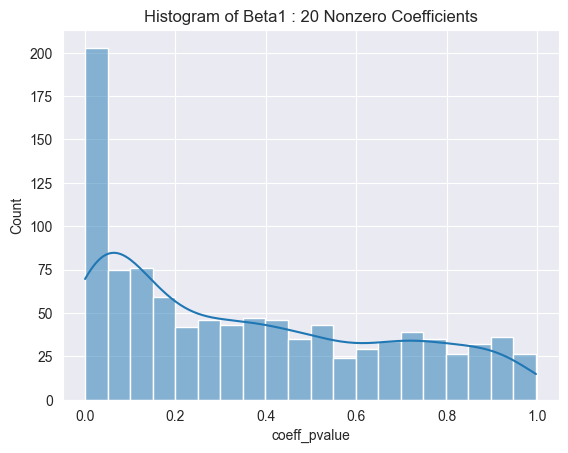

In [75]:
sns.histplot(data=simulation_df[simulation_df['Setting'] == '20 Nonzero Coefficients'], x='coeff_pvalue', kde=True,
             bins=20).set_title('Histogram of Beta1 : 20 Nonzero Coefficients')

Text(0.5, 1.0, 'Hisgoragram of Beta1: Global Null')

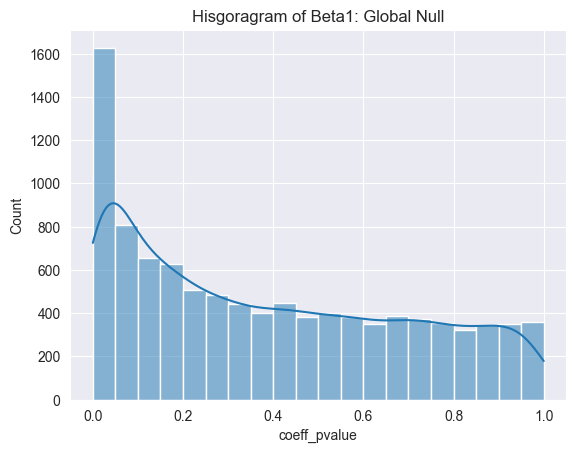

In [100]:
import seaborn as sns

sns.histplot(data=simulation_df[simulation_df['Setting'] == 'Global Null'], x='coeff_pvalue', kde=True,
             bins=20).set_title('Hisgoragram of Beta1: Global Null')

Text(0.5, 1.0, 'Histogram of Beta1 : 20 Nonzero Coefficients')

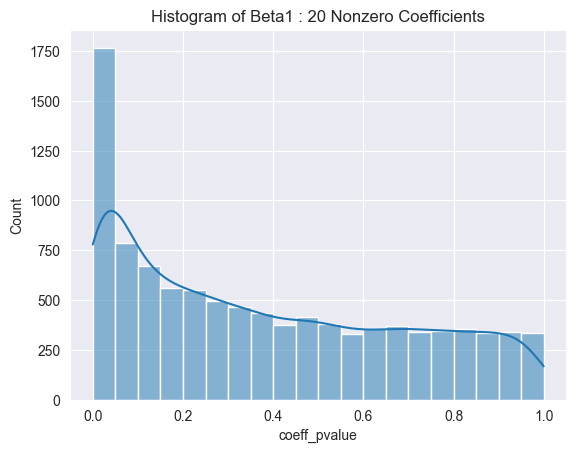

In [101]:
sns.histplot(data=simulation_df[simulation_df['Setting'] == '20 Nonzero Coefficients'], x='coeff_pvalue', kde=True,
             bins=20).set_title('Histogram of Beta1 : 20 Nonzero Coefficients')

Text(0.5, 1.0, 'Histogram of Beta1: Both Settings')

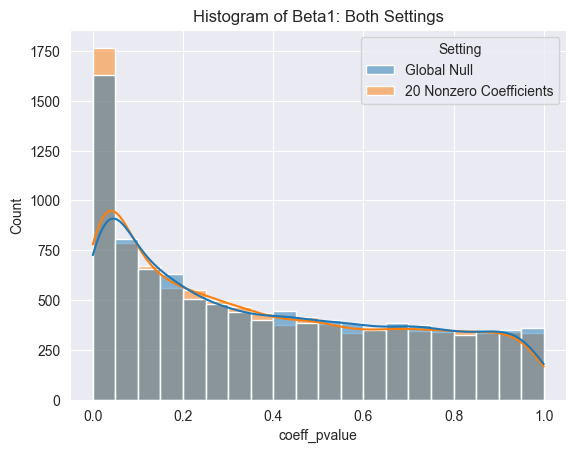

In [102]:
sns.histplot(data=simulation_df, x='coeff_pvalue', hue='Setting', kde=True, bins=20).set_title(
    'Histogram of Beta1: Both Settings')

### Conditional Randomization Test

In [64]:
import numpy as np

def draw_sample(X, j):
    params = get_data_statistics(X)
    X_tilde = sample_from_gaussian(X, j, params["X_mu"], params["X_sigma"])
    return X_tilde


import numpy as np


# taken from https://github.com/shaersh/ecrt/blob/main/src/sampling_functions.py
def get_data_statistics(X):
    mu = np.mean(X, axis=0)
    sigma = np.cov(X.T)
    params_dict = {"X_mu": mu,
                   "X_sigma": sigma}
    return params_dict


def create_conditional_gauss(X, j, mu, sigma):
    """"
    This function computes the conditional distribution of X_j given X_-j.

    :param X: A batch of b samples with d features.
    :param j: The index of the feature under test.
    :param mu, sigma: The mean and covariance of X.
    :return: The mean and covariance of the conditional distribution.
    """
    # Indices of other features
    idx = np.arange(X.shape[1]) != j

    # Mean and covariance for other features
    mu_2 = mu[idx]
    sigma_22 = sigma[np.ix_(idx, idx)]

    # Covariance between X_j and X_-j
    sigma_12 = sigma[j, idx]
    sigma_21 = sigma[idx, j]

    # Conditional variance of X_j given X_-j
    sigma_bar = sigma[j, j] - sigma_12 @ np.linalg.inv(sigma_22) @ sigma_21

    # Conditional mean vector for each sample
    mu_bar_vec = mu[j] + sigma_12 @ np.linalg.inv(sigma_22) @ (X[:, idx].T - mu_2).T

    return mu_bar_vec, np.sqrt(sigma_bar)


def sample_from_gaussian(X, j, X_mu, X_sigma):
    """
    This function samples the dummy features for gaussian distribution.
    :param X: A batch of b samples with d features.
    :param j: The index of the feature under test.
    :param X_mu, X_sigma: The mean and covariance of X.
    :return: A copy of the batch X, with the dummy features in the j-th column.
    """
    mu_tilde, sigma_tilde = create_conditional_gauss(X, j, X_mu, X_sigma)
    n = X.shape[0]
    X_tilde = X.copy()
    Xj_tilde = np.random.normal(mu_tilde, sigma_tilde, (n, 1))
    X_tilde[:, j] = Xj_tilde.ravel()
    return X_tilde


def crt_test(X, y, original_coeff, j, k=1000):
    Xj = X[:, j].copy()
    permuted_coeffs = []
    for _ in range(k):
        X[:, j] = draw_sample(X, j) # here sample as in https://github.com/shaersh/ecrt/blob/main/src/sampling_functions.py

        permuted_coeff = sm.Logit(y, sm.add_constant(X)).fit(disp=0).params[1]
        permuted_coeffs.append(permuted_coeff)
        X[:, j] = Xj
    N = np.sum(np.abs(permuted_coeffs) >= np.abs(original_coeff))

    one_sided = (1 / (k + 1)) * (N + 1)
    p_value = 2 * min(one_sided, 1 - one_sided)

    return p_value

In [65]:
# Assuming simulate_ar, compute_setting1_output, and compute_setting2_output are defined elsewhere

def crt_simulation(iterations=100, n=500, p=200):
    """
    Simulate the two Random variables and fit the models.
    n: Number of observations
    p: Number of variables
    iterations: Number of iterations
    """
    # Assuming p-1 because we're excluding the intercept
    total_rows = iterations * 2
    results = np.empty((total_rows, 5), dtype=object)  # Pre-allocate NumPy array

    idx = 0
    for i in range(iterations):

        if i % 100 == 0: print(f"Reached iteration {i}..")
        try:
            xs = simulate_ar(n, p)
            #xs = simulate_ar_V2(n, p)

            ys1 = compute_setting1_output(xs)
            ys2 = compute_setting2_output(xs)

            model1 = sm.Logit(ys1, sm.add_constant(xs)).fit(disp=0)
            model2 = sm.Logit(ys2, sm.add_constant(xs)).fit(disp=0)

            crt_value1_setting1 = crt_test(xs, ys1, model1.params[1], 1, k=10000)
            crt_value1_setting2 = crt_test(xs, ys2, model2.params[1], 1, k=10000)

            # add only coeff beta1
            results[idx] = [i, 'Global Null', n, p, crt_value1_setting1]
            idx += 1
            results[idx] = [i, '20 Nonzero Coefficients', n, p, crt_value1_setting2]
            idx += 1

        except np.linalg.LinAlgError:
            print(f"Skipping iteration {i} due to singular matrix error.")
            continue

    return results


crt_results = simulation(iterations=1000)

Reached iteration 0..
Reached iteration 100..


C:\Users\danpa\PycharmProjects\CStat_assignments\venv\lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\danpa\PycharmProjects\CStat_assignments\venv\lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Skipping iteration 137 due to singular matrix error.
Reached iteration 200..
Reached iteration 300..
Reached iteration 400..


C:\Users\danpa\PycharmProjects\CStat_assignments\venv\lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\danpa\PycharmProjects\CStat_assignments\venv\lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Skipping iteration 460 due to singular matrix error.
Reached iteration 500..
Reached iteration 600..
Reached iteration 700..
Reached iteration 800..
Reached iteration 900..


Text(0.5, 1.0, 'Histogram of Beta1: Global Null')

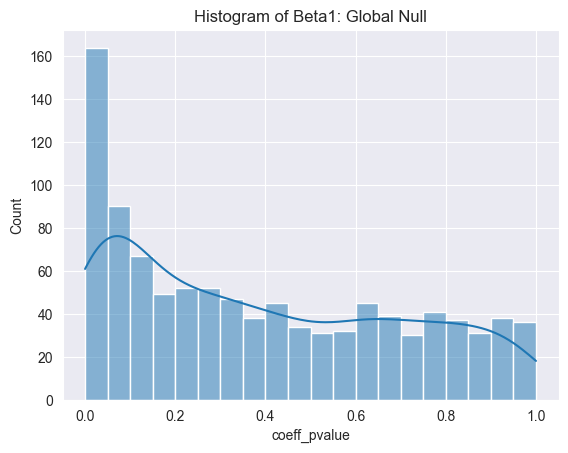

In [78]:
simulation_crt_df = pd.DataFrame(columns=['SimIdx', 'Setting', 'n', 'p', 'coeff_pvalue'], data=crt_results)
import seaborn as sns

sns.histplot(data=simulation_crt_df[simulation_crt_df['Setting'] == 'Global Null'], x='coeff_pvalue', kde=True,
             bins=20).set_title('Histogram of Beta1: Global Null')

Text(0.5, 1.0, 'Histogram of Beta1 : 20 Nonzero Coefficients')

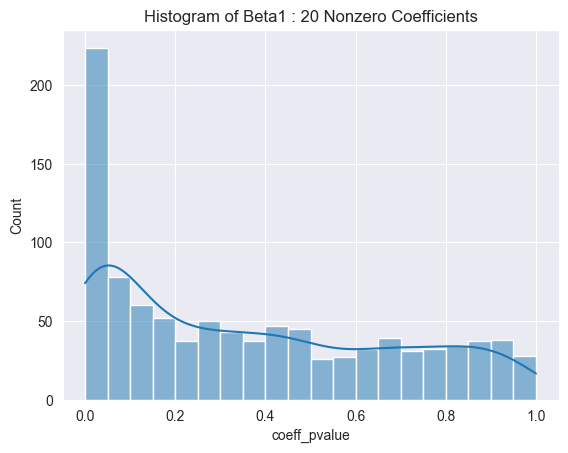

In [79]:
sns.histplot(data=simulation_crt_df[simulation_crt_df['Setting'] == '20 Nonzero Coefficients'], x='coeff_pvalue', kde=True,
             bins=20).set_title('Histogram of Beta1 : 20 Nonzero Coefficients')

Text(0.5, 1.0, 'Histogram of Beta1: Both Settings - CRT')

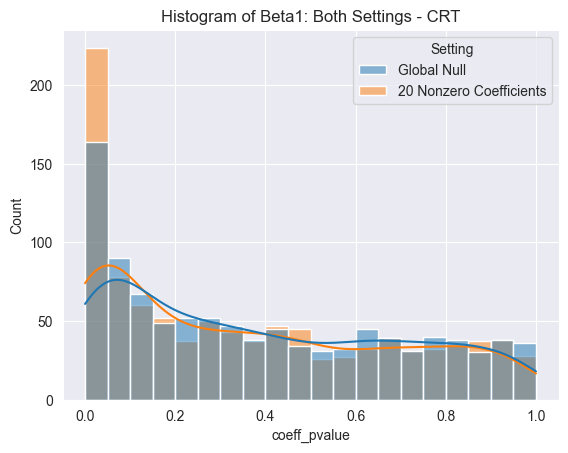

In [83]:
sns.histplot(data=simulation_crt_df, x='coeff_pvalue', hue='Setting', kde=True, bins=20).set_title(
    'Histogram of Beta1: Both Settings - CRT')

Text(0.5, 1.0, 'Histogram of Beta1: Both Settings')

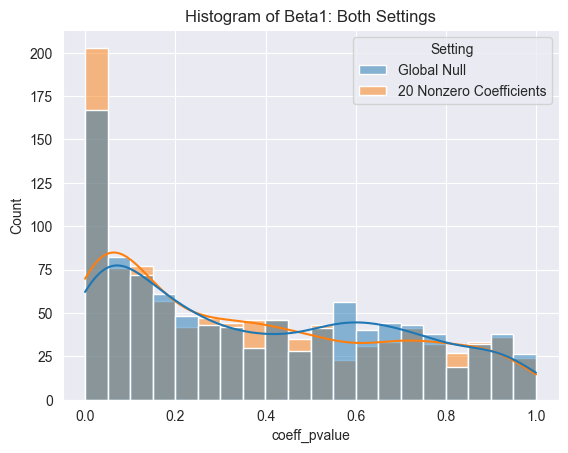

In [82]:
sns.histplot(data=simulation_df, x='coeff_pvalue', hue='Setting', kde=True, bins=20).set_title(
    'Histogram of Beta1: Both Settings')